In [1]:
import numpy as np
np.random.seed(10)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import gc
import sklearn
import scipy.sparse
import lightgbm as lgb
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#from ._tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.manifold import TSNE

from itertools import product
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier, AdaBoostRegressor)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn import manifold, datasets

In [2]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [3]:
import xgboost as xgb 

In [4]:
import os
#DATA_FOLDER = 'C:\\Users\\Angadvir\\.kaggle\\competitions\\competitive-data-science-final-project'
#DATA_FOLDER = 'C:\\Users\\Angadvir\\kaggle_competition_dataset'
DATA_FOLDER = 'C:\\Recovery_2\\Angadvir_PC\\kaggle_competition_dataset'

item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
sales_train     = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [5]:
print(item_categories.shape)
#print(item_categories[:3])
print(items.shape)
#print(items[:3])
print(sales_train.shape)
#print(sales_train[:3])
print(shops.shape)
#print(shops[50:54])
print(test.shape)

#data_set = np.c_[item_categories, items, sales_train, shops]

#Constructing a Panda dataFrames:
item_cat = pd.DataFrame(item_categories, columns = ['item_category_name','item_category_id']) 
items = pd.DataFrame(items, columns=['item_name','item_id','item_category_id'])
shops = pd.DataFrame(shops, columns=['shop_name','shop_id'])
sales_data = pd.DataFrame(sales_train, columns =['date','date_block_num','shop_id','item_id','item_price','item_cnt_day'])
test_data = pd.DataFrame(test, columns = ['ID', 'shop_id', 'item_id'])
 
sales_data['Day']=[d.split('.')[0] for d in sales_data.date]
sales_data['Month']=[d.split('.')[1] for d in sales_data.date]
sales_data['Year']=[d.split('.')[2] for d in sales_data.date]
sales_data['Year'] = pd.to_numeric(sales_data['Year'])    

#print(sales_data[-3:])
sales_data = sales_data.drop(['date'],axis=1)
#print(sales_data[-3:])
#print(item_cat[-3:])
#print(items[-3:])

shops.shop_id = pd.to_numeric(shops.shop_id)
#print(item_cat[:3])
#print(items[:3])
#print(shops[:3])
#print(sales_data[:3])

(84, 2)
(22170, 3)
(2935849, 6)
(60, 2)
(214200, 3)


In [6]:
print((sales_data.loc[sales_data.date_block_num == 33]).shape)

(53514, 8)


In [7]:
print(items.head(3))
print(item_categories.head(3)) 
#print(test_data.head(10))
#print(test_data.tail(10)) 
print(sales_data[-10:])
sales_data1 = sales_data.sort_values(by=['item_id'])
test_data1 = test_data.sort_values(by=['item_id'])
print(sales_data1.head(10))
print(sales_data1.loc[sales_data1.item_id==22167].shape)
print(test_data1.tail(10)) 

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40  
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
         date_block_num  shop_id  item_id  item_price  item_cnt_day Day Month  \
2935839              33       25     7315       399.0           1.0  24    10   
2935840              33       25     7409       299.0           1.0  31    10   
2935841              33       25     7393       349.0           1.0  11    10   
2935842              33       25     7384       749.0           1.0  10    10   
2935843              33       25     7409       299.0           1.

In [8]:
#Defining 'cats' or narrower categories: 
l_cat = list(item_categories.item_category_name)

for ind in range(1,8):
    l_cat[ind] = 'Access'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'

for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'

for ind in range(28,32):
    l_cat[ind] = 'CD games'

for ind in range(32,37):
    l_cat[ind] = 'Card'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'
    
for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Gifts'

for ind in range(73,79):
    l_cat[ind] = 'Soft'
    
item_categories['cats'] = l_cat
print(item_categories.tail(5), item_categories.shape)

           item_category_name  item_category_id                       cats
79                  Служебные                79                  Служебные
80         Служебные - Билеты                80         Служебные - Билеты
81    Чистые носители (шпиль)                81    Чистые носители (шпиль)
82  Чистые носители (штучные)                82  Чистые носители (штучные)
83           Элементы питания                83           Элементы питания (84, 3)


In [9]:
#Framework: 
#1. Create features ('target', 'target_shop', 'target_item', 'lag_1_shop'...) for the validation set. 
#2. Train base learners on train set and make predictions on 'validation set'.  
#3. Create 'meta-features' through predictions on, training and validation, sets.
#4. Train meta-model on the meta-features and improve the model, depending on rmse of predicted validation set. 
#5. Train "re-trained meta-model" on the meta-features and test on the test-set. 
#6. Report the predictions. 

#Explicit features:
#1. shop_id, item_id, date_block_num, 
#2. y-labels - 'target'.
#print(item_cat[:4])
#print(sales_data[:4])
test_data = pd.DataFrame(test, columns = ['ID', 'shop_id', 'item_id'])

sales_pivot = sales_data.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day', aggfunc='sum').fillna(0.0)
#print(sales_pivot.head(2)) 

sales_p = sales_pivot.reset_index()
sales_p['shop_id']= sales_p.shop_id.astype('str')
sales_p['item_id']= sales_p.item_id.astype('str')

item_to_cat_df = items.merge(item_categories[['item_category_id','cats']], how="inner", on="item_category_id")[['item_id','cats']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str') #Converting to string

sales_p = sales_p.merge(item_to_cat_df, how="inner", on="item_id")

#Including Label Encoding for item category names: 
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
sales_p[['cats']] = number.fit_transform(sales_p.cats)
sales_p = sales_p[['shop_id', 'item_id', 'cats'] + list(range(34))]
#print(sales_p.head(2))
#print(sales_p.tail(2))
print(sales_p.shape) #Label Encode all categories from 0 to n_classes-1.
#print(sales_p.cats[:-5]) 

#Merge 'cats' into the test dataframe, through a mapping function: 
dict_df = pd.Series(sales_p.cats.values, index=sales_p.item_id).to_dict()
dict_int = {int(k):int(v) for k,v in dict_df.items()}

first2pairs = {k: dict_int[k] for k in list(dict_int)[:2]}
print(first2pairs)

#print(dict_df)
#Converting values of dictionary to type 'int': 
#for sub in dict_df:
#    for key in sub: 
#        sub[key] = int(sub[key])

#Create a new dataframe from dictionary, before merging: 
new_df = pd.DataFrame.from_dict(dict_df, orient = 'index')
#new_df = pd.DataFrame(new_df.column, columns=['cats'])
#print(new_df.head(5), new_df.shape)
new_df = new_df.reset_index()
new_df.columns =['item_id', 'cats'] 
#print(new_df[5210:5215]) 

#Converting all dtypes in both 'test_data' and 'new_df' to type, int:
new_df['item_id'] = new_df['item_id'].astype('int')
new_df['cats'] = new_df['cats'].astype('int')

test_data['item_id'] = test_data['item_id'].astype('int')
test_data['shop_id'] = test_data['shop_id'].astype('int')

#Merging the 2 DataFrames:
#test_data['cats'] = test_data['item_id'].map(dict_df)
test_merge = pd.merge(test_data, new_df, how='left', on=['item_id'])
#print(test_data[500:504])

#Merge into the test_data set: 
#test_merge = pd.merge(test_data, new_df, how='left', on=['item_id'])

#test_merge = test_merge.cats.fillna(0)
#print(test_data[:3])
#print(test_merge[5000:5010])

#Sort the test_merge dataset: 
test_merge = test_merge.sort_values(by=['item_id'])
#print(test_merge[1000:1010])

#Count number of 'NaN' in the item_id: 
num_nan = test_merge.cats.isnull().sum()
print('Number of NaN is : ', num_nan)

#Filter in the number of NaN's: 
test_nan = test_merge[test_merge.isnull().any(axis=1)]
#print(test_nan.head(5), test_nan.shape)
#print(test_nan[:3])

#Increase the item_id values by 1 and map the cats to the new item_id's:
test_nan1 = test_nan.copy()
test_nan1['item_id1'] = test_nan1.item_id + 1
test_nan1 = test_nan1.drop(['cats'], axis = 1)
test_nan1['item_id1'] = test_nan1['item_id1'].astype('int')
test_nan1['cats'] = test_nan1['item_id1'].map(dict_df)
print(test_nan1.tail(5))

#Store the items with 'NaN' as 'cats' value:
items_nan = test_nan.groupby('item_id').agg({'item_id': 'nunique'})
#print(items_nan.head(5), items_nan.tail(5), items_nan.shape)
print('Max category number is', test_merge.cats.max()) 

test_nonan = test_merge.dropna()

test_nonan.item_id = test_nonan.item_id+1
print('TEST_NONAN IS GIVEN BY: ',test_nonan[500:510]) 

#Create a dictionary: 
#dict_df1 = pd.Series(test_nonan.cats.values, index=test_nonan.item_id).to_dict()
#dict_int1 = {int(k):int(v) for k,v in dict_df1.items()}
#first2pairs1 = {k: dict_int1[k] for k in list(dict_int1)[:2]}

#Filter out the item_id with max 'cats' value:
max_cat = test_merge[test_merge.cats==19]

#Fill up the NaN's:

#categ_cnt = [0 for i in range(19)]
categ_cnt = test_merge.groupby('cats')['item_id'].count()

print(categ_cnt.head(3))

#print(max_cat.head(5), max_cat.tail(5))

#Categorize the NaN item_id to the nearest item_id with a 'cats': 

#print()
#print(test_data[-5:])
#print(dict_df)
print(test_merge.item_id.max())
#print(test_merge[test_merge.item_id==22167])
#print(test_only)

(424124, 37)
{30: 7, 31: 7}
Number of NaN is :  15246
            ID  shop_id  item_id  item_id1  cats
17889    17889        3    22137     22138   NaN
7689      7689        4    22137     22138   NaN
58689    58689       25    22137     22138   NaN
53589    53589       26    22137     22138   NaN
191289  191289       46    22137     22138   NaN
Max category number is 19.0


C:\Users\Angadvir\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


TEST_NONAN IS GIVEN BY:              ID  shop_id  item_id  cats
200919  200919       44       63   7.0
17319    17319        3       63   7.0
206019  206019       39       63   7.0
12219    12219        6       63   7.0
199428  199428       44       65   7.0
61728    61728       22       65   7.0
10728    10728        6       65   7.0
168828  168828       37       65   7.0
77028    77028       15       65   7.0
20928    20928        2       65   7.0
cats
0.0     3066
1.0    14490
2.0    18732
Name: item_id, dtype: int64
22167


In [10]:
#Exploring the test data set:
#print(test_data[:5])
#print(item_categories[-5:])
#print(items[:5])
#print(item_to_cat_df[-5:])
#print(sales_p[:5], sales_p.shape)

#Merge cats to test data set:
#print(sales_p[-5:])

num_shops = test.groupby('shop_id')['shop_id'].nunique()
num_items = test.groupby('item_id')['item_id'].nunique()
num_items1 = sales_p.groupby('item_id')['item_id'].nunique()

test_items = num_items.index.values.tolist()
test_shops = num_shops.index.values.tolist()

#Change item_id and shop_id into 'int' type:
sales_p.item_id = sales_p.item_id.astype(int)
sales_p.shop_id = sales_p.shop_id.astype(int)
T_7 = sales_p.loc[sales_p.item_id.isin(test_items) & sales_p.shop_id.isin(test_shops)]

T_7_it = T_7.groupby('item_id').agg({'item_id': 'nunique'})
T_7_items = T_7_it.index.values.tolist()

T_7_sh  = T_7.groupby('shop_id').agg({'shop_id':'nunique'})
T_7_shops = T_7_sh.index.values.tolist()

print('T_7_items SHAPE IS GIVEN BY: ', len(T_7_items))
print('T_7_shops SHAPE IS GIVEN BY: ', len(T_7_shops))

print('T_7.shape ["Test Shops" and "Test items" present in the Train set]')
print(T_7.shape)
print(T_7[:2])
print('Make a note of these test items present in the train set as well: ')

#Counting number of unique Test items and shops, found in the train set:
test_uni_items = T_7.groupby('item_id').agg({'item_id': 'nunique'})
test_uni_shops = T_7.groupby('shop_id').agg({'shop_id': 'nunique'})

print('Unique items in T_7 are: ', test_uni_items.shape)
print('Unique shops in T_7 are: ', test_uni_shops.shape)
print('All test items: ', num_items.shape)
print('All test shops: ', num_shops.shape)
#Filter the train set with only shops and items given in the test set:
train_fil = 2

test_set44 = sales_p.loc[~(sales_p['item_id'].isin(test_items))].dropna()
test_set55 = sales_p.loc[~(sales_p['shop_id'].isin(test_shops))].dropna()

items_train_uni = test_set44.groupby('item_id').agg({'item_id': 'nunique'})
shops_train_uni = test_set55.groupby('shop_id').agg({'shop_id': 'nunique'})

#items_train_uni = sales_p.groupby('item_id').agg({'item_id': 'nunique'})
#shops_train_uni = sales_p.groupby('shop_id').agg({'shop_id': 'nunique'})

#sales_p[~df1.isin(df2)].dropna()

print(sales_p.shape)
#print(test_set4.shape, T_7.shape)

#print(items_train_uni.shape, shops_train_uni.shape, items_train_uni.shape[0]*shops_train_uni.shape[0])
#print(num_items.shape, num_shops.shape, num_items.shape[0]*num_shops.shape[0])

#print('Number of items present only in test set [New Items]: ',-1*(items_train_uni.shape[0]-num_items1.shape[0]))
print('Number of items present in both test and train: ',-1*(items_train_uni.shape[0]-num_items1.shape[0]))

items_train_uni['index1'] = items_train_uni.index
#num_items['index1'] = num_items.index

#num_items1 = num_items.reset_index()
#print(items_train_uni[-5:])
df_1 = []
#Constructinga  dataframe of train only items: 
df_1 = pd.DataFrame(items_train_uni.index, columns =['item_id'])
#print(df_1.tail(5), test_data.tail(5))

#Merging the 2 DataFrames ['test_data' and 'df_1']:
merged_df = test_data.merge(df_1, how='left', on=['item_id'], indicator=True)
#Left data is 'df_1' and right dataframe is 'test_data':

#df.merge(other, how='left', indicator=True)
print(merged_df.tail(5), merged_df.shape)
test_only = merged_df[merged_df['_merge']=='left_only']
print('test_only_data_frame' ,test_only[-5:])
print('"test_only" SHAPE is GIVEN BY: ', test_only.shape)

#Count the unique number of item_id and shop_id in 'test_only' dataframe:
test_only_shops = test_only.groupby('shop_id').agg({'shop_id': 'nunique'})
test_only_items = test_only.groupby('item_id').agg({'item_id': 'nunique'})

print('Number of shops which contain test_only_items: ', test_only_shops.shape[0])
print('Number of items which are in test_only', test_only_items.shape[0])
print('Shops which sell the test_only_items are ', test_only_shops[:3])

#df1[(~df1.col1.isin(common.col1))]

#df.loc[df['favorite_color'] == 'yellow']
#print(test_set1.shape, test_set2.shape, test_set3.shape)
print(T_7.shape)
print('Sales_p', sales_p.shape)
print('Test_only is given by: ', 214200 - T_7.shape[0])

T_7_items SHAPE IS GIVEN BY:  4716
T_7_shops SHAPE IS GIVEN BY:  42
T_7.shape ["Test Shops" and "Test items" present in the Train set]
(111404, 37)
   shop_id  item_id  cats    0    1    2    3    4    5    6 ...    24   25  \
2        2       30     7  0.0  0.0  1.0  0.0  0.0  1.0  0.0 ...   0.0  0.0   
3        3       30     7  0.0  4.0  5.0  2.0  2.0  1.0  0.0 ...   0.0  0.0   

    26   27   28   29   30   31   32   33  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  

[2 rows x 37 columns]
Make a note of these test items present in the train set as well: 
Unique items in T_7 are:  (4716, 1)
Unique shops in T_7 are:  (42, 1)
All test items:  (5100,)
All test shops:  (42,)
(424124, 37)
Number of items present in both test and train:  4737
            ID  shop_id  item_id     _merge
214195  214195       45    18454  left_only
214196  214196       45    16188  left_only
214197  214197       45    15757  left_only
214198  214198       45    1964

In [11]:
#print(test_nonan.head(5), test_nonan.shape)
#print(test_nan.head(5), test_nan.shape)
#Filling all NaN's with previous 'cats' values:
#print(test_merge[2222:2228])
check = []
#print(test_merge.item_id[2])

#Groupby and Aggregate:
test_group = test_merge.groupby('item_id').agg({'cats':'count'})
#Reset Index():
test_group = test_group.reset_index()
#Rename columns:
test_group = test_group.rename(index=str, columns={"item_id": "item_id", "cats": "cat_count"})
#Mapping 'cats' to test_group:
test_group['item_id']= test_group['item_id'].astype('int')
test_group['cat_count']= test_group['cat_count'].astype('int')
new_df['item_id']= new_df['item_id'].astype('int')
new_df['cats']= new_df['cats'].astype('int')
test_group['cats'] = test_group.item_id.map(dict_int)

#Forward fill all the 'nan' values in the dataframe:
test_group = test_group.fillna(method='ffill')
#print(test_group.head(3)) 

#Directly filling up the test data with forward fill no.:
test_merge = test_merge.fillna(method='ffill')
print(test_merge.shape)

#Total sale by each of the shops in each of the months:
print(sales_p.head(3), sales_p.shape)
sales_group = sales_p.groupby(['shop_id'])[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]].sum()
#df.groupby(['Country', 'Item_Code'])[["Y1961", "Y1962", "Y1963"]].sum()
#print(list(sales_p.columns.values))
#print(sales_group.head(10))
#Find types of items sold by each shop in each month:
#FILL UP THE NEW ITEMS IN THE TEST SET BY THE PREDICTED MEAN FOR THE SHOPS SELLING THOSE ITEMS IN THE NEXT MONTH:
#print items ONLY in the test set:
test_only_gr = test_only.groupby('shop_id') #.agg({'item_id':'sum'})
#print(test_only_gr.head(1))
#Fill in the item_cnt_day for the these items by the mean shop sales of each of the 42 shops in the train set:
#JUST FILL THE UNKNOWN ITEMS IN THE TRAIN SET AND PUT IN THE MEAN VALUE FOR EACH OF THE 'ITEM_CNT_DAY' VALUES:
#Finding the average 'item_cnt_day' value:
sales_group1 = sales_p.groupby(['shop_id'])
sales_sort = sales_p.sort_values(by=['shop_id', 'item_id'])
#print(sales_group1.head(1))
#print(sales_sort.head(30))
#print(sales_sort.tail(30))
#Take the mean of only the months and create another column for the mean no. of items sold per month, for each shop.
sales_sort['mean_cnt'] = sales_sort[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]].mean(axis=1)
#print(sales_sort.head(5))

sales_sort_gr = sales_sort.groupby('shop_id').agg({'mean_cnt':'mean'})

sales_agg = sales_sort_gr.reset_index()
#print(sales_agg)

dict_sales = pd.Series(sales_agg.mean_cnt.values, index=sales_agg.shop_id).to_dict()
dict_int1 = {int(k):float(v) for k,v in dict_sales.items()}

#first2ps = {t: dict_int[t] for t in list(dict_int1)[:2]}
#print(first2ps)
#print(dict_int1)
#print(test_only_gr['shop_id'].nunique())
#Fill in the test_only items in the train set and then filter the train set (containing only the test set shops and items):
train_new = pd.merge(sales_sort, test_merge, on=['item_id'], how='right') 
#print(train_new[:3])
#print(test_merge[:3])
#Append values in a dataframe. Append 'shop_id', 'item_id','cats' which are in 'test_only' fill the months with 'mean' value

#Creating dataframe to append:
test_merge['shop_id'] = test_merge['shop_id'].astype('int')
test_merge['item_id'] = test_merge['item_id'].astype('int')
test_merge['cats'] = test_merge['cats'].astype('int')

#Re-ordering the index:
test_merge = test_merge.sort_index(axis = 0, ascending=True)
print('ASCENDING ORDER IS: ')
#print(test_merge.head(10))
test_merge['z'] = test_merge['shop_id'].map(dict_int1)
#print(test_merge[:3], test_merge.shape) 
mean_cnt1 = pd.DataFrame(test_merge.z, columns=['z'])
#print(mean_cnt1)
df = pd.DataFrame(pd.np.tile(mean_cnt1, (1, 35)))

#print(df.head(5), df.shape)
#Drop the 'z' column: 
test_merge= test_merge.drop(['z'], axis=1)
#print(test_merge.tail(3))
#print(df.tail(3))
#Merge the months dataframe:
#test_merged = pd.merge(test_merge, df, on=[0], how='left')

test_merged = []

test_merged = pd.concat([test_merge, df], axis=1, join_axes=[test_merge.index]).reindex(test_merge.index)

#print(test_merged.tail(3), test_merged.shape)
#test_merged = test_merged.drop_duplicates(keep='first')
test_merged = test_merged.drop(test_merged.columns[4], axis=1)

#Rename columns:
df.rename(columns={df.columns[1]: "whatever" })
for i in range(4,38):
    test_merged = test_merged.rename(columns={test_merged.columns[i]: i-4 })
#df.rename(columns=lambda x: x[1:], inplace=True)
#print(test_merged.tail(3), test_merged.shape) 
#Fill in the test_only items in the train set and then filter the train set (containing only the test set shops and items):
print(test_only.item_id.shape)

#Drop column = 'ID':
test_merged = test_merged.drop(test_merged.columns[0], axis=1)

####################################################
#'test_merged' DATASET NEEDS TO BE RUN 1st:
test_items_only_set= test_merged.loc[~(test_merged['item_id'].isin(T_7_items))].dropna()
test_shops_only_set = test_merged.loc[~(test_merged['shop_id'].isin(T_7_shops))].dropna()
print(T_7_items[:5], T_7_shops[:5])

#PRINTING THE NUMBER OF ITEMS EXCLUSIVEY IN THE TEST SET:
print('items exclusively in the test set: ', test_items_only_set.shape)
#print('shops exclusively in the test set: ', test_shops_only_set.shape)

#Selecting item_ids which are only in the test set:
test_set4 = sales_p.loc[(sales_p['item_id'].isin(test_items))]
test_set5 = sales_p.loc[(sales_p['shop_id'].isin(test_shops))]

#print('test_set4 printed is: ', test_set4[:2])
T_Exc_it = test_merged.loc[~(test_merged.item_id.isin(T_7_items))]
print('T_Exc_it is given by: ', T_Exc_it.shape)

N_in_T7 = test_merged.loc[(test_merged.item_id.isin(T_7_items))]

print(N_in_T7.shape)

print(N_in_T7[:3])

N_not_T7 = test_merged.loc[~(test_merged.item_id.isin(T_7_items))]

print(N_not_T7.shape)
print(len(T_7_items))
T_Exc = test_merged.loc[~(test_merged.item_id.isin(T_7_items)) & (test_merged.shop_id.isin(test_shops))]
print('T_Exc.shape is given by: ', T_Exc.shape)
####################################################

test_merged_f = test_merged #.loc[test_merged.item_id.isin(test_only.item_id)]
print('"Test_merged_f" shape is given by: ', test_merged_f.shape) 

print(sales_p.shape)
#Filter HERE:
train_test_both = []
train_test_both = pd.merge(test_merged_f, sales_p, how = 'inner', on = ['item_id', 'shop_id'])

train_test_it_sh = train_test_both[['item_id', 'shop_id']]
print(train_test_it_sh[:2])
print('train_test_it_sh shape is given by: ',train_test_it_sh.shape)

train_test_comm_data = sales_p.loc[(sales_p['item_id'].isin(train_test_it_sh.item_id)) & sales_p['shop_id'].isin(train_test_it_sh.shop_id)]

print('train_test_comm_data SHAPE is given by: ', train_test_comm_data.shape)

#Merge the 2 datasets ['train_set_comm_data', 'test_merged_f'] and filter out items in 'test_merged_f' only:
test_exc_items = pd.merge(test_merged_f, train_test_comm_data, how ='outer',on =['item_id'] ,indicator='indicator_column')

test_exc_it = test_exc_items.loc[test_exc_items['indicator_column']=='both']
#print(test_exc_it[:3])

print('TEST_EXC_IT shape is given by: ', test_exc_it.shape)

#test_only_it1 = test_merged_f[(~test_merged_f.item_id.isin(train_test_comm_data.item_id))]
#print('test_only_it SHAPE is given by: ', test_only_it1.shape)

#Check the common items in test and train set: 
num_shops = test_data.groupby('shop_id')['shop_id'].nunique()
num_items = test_data.groupby('item_id')['item_id'].nunique()
test_items = num_items.index.values.tolist()
test_shops = num_shops.index.values.tolist()

num_shops_train = sales_p.groupby('shop_id')['shop_id'].nunique()
num_items_train = sales_p.groupby('item_id')['item_id'].nunique()
train_items = num_items_train.index.values.tolist()
train_shops = num_shops_train.index.values.tolist()

#train_shops = num_shops_train.index.values.tolist()
#print('These are the COMMON SHOPS in both train and test set:')
common_shops = sales_p.loc[sales_p['shop_id'].isin(test_shops)]
#print(common_shops.shape)
uniq_shops = common_shops.groupby('shop_id')['shop_id'].nunique()
#print('No. of unique shops in BOTH TEST and TRAIN', uniq_shops.shape)
#print('shops in BOTH TEST and TRAIN: ')
#print(uniq_shops) 
#print('Number of unique shops in TRAIN SET: ',len(train_shops))

#print('THESE ARE THE COMMON ITEMS IN TRAIN AND TEST: ')
comm_prod = sales_p.loc[sales_p['item_id'].isin(test_items)].shape
#print(comm_prod, len(comm_prod))
train_items = [int(y) for y in train_items]

test_items_arr = [0 for i in range(len(test_items))]
for i in range(len(test_items)):
    test_items_arr[i] = test_items[i]
comm = bool(set(test_items_arr).intersection(train_items))  

#print(comm)
#Take these train items separately:
#print(test_items[:10])

#print(test_items_arr==30)

#Append the test_only items in the training DataFrame:
train_set_all = sales_p.append(test_merged_f)
print(train_set_all.shape)
print(train_set_all.tail(5))
 
#Print out all the shops sale (in the test set) by month:
#TESTING CODE:
#Filter out the test_only shops and items from all the training set:
#Convert 'test_items' to a numpy array: 
#test_items = np.asarray(test_items)
#print(test_items[:10])
test_set_only = train_set_all.loc[train_set_all['item_id'].isin(test_items)]

#df.loc[df['column_name'].isin(some_values)] 
print('TEST_SET_ONLY.shape: ')
#print(test_set_only.shape)
#print(len(test_items), len(test_shops)) 
#print(test_items.loc[test_items==21425])
#test_set_only1 = train_set_all.loc[train_set_all.item_id.isin(test_items)]
#print('TESTING ONLY', test_set_only.shape)
#Find common 'items' and 'shops' found both in test and train set:

#Test Set:
#num_shops = test.groupby('shop_id')['shop_id'].nunique()
#num_items = test.groupby('item_id')['item_id'].nunique()
#test_items = num_items.index.values.tolist()
#test_shops = num_shops.index.values.tolist()

#Train Set:
num_shops_train = sales_p.groupby('shop_id')['shop_id'].nunique()
num_items_train = sales_p.groupby('item_id')['item_id'].nunique()
train_items = num_items_train.index.values.tolist()
train_shops = num_shops_train.index.values.tolist()
print('TRAIN SET DATA: ',len(train_items), len(train_shops))
test_items = pd.DataFrame(test_items, columns=['item_id'])
train_items = pd.DataFrame(train_items, columns=['item_id'])

#Find common items in train and test set:
s1 = pd.merge(train_items, test_items, how='inner', on=['item_id'])
print(s1.shape, test_items.shape, train_items.shape)
#print(train_items.tail(10), test_items.tail(10))
#RECREATE THE TEST DATAFRAME WITH AVERAGE SALES OF EVERY SHOP:

print(train_set_all.shape) 

(214200, 4)
   shop_id  item_id  cats    0     1    2    3    4    5    6 ...    24   25  \
0        0       30     7  0.0  31.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
1        1       30     7  0.0  10.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
2        2       30     7  0.0   0.0  1.0  0.0  0.0  1.0  0.0 ...   0.0  0.0   

    26   27   28   29   30   31   32   33  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 37 columns] (424124, 37)
ASCENDING ORDER IS: 
(214200,)
[30, 31, 32, 33, 38] [2, 3, 4, 5, 6]
items exclusively in the test set:  (16128, 37)
T_Exc_it is given by:  (16128, 37)
(198072, 37)
   shop_id  item_id  cats         0         1         2         3         4  \
0        5     5037     5  0.177542  0.177542  0.177542  0.177542  0.177542   
2        5     5233     5  0.177542  0.177542  0.177542  0.177542  0.177542   
3        5     5232     5  0.177542  0.177542  0.17754

C:\Users\Angadvir\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:565: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  self.left, self.right)


TEST_EXC_IT shape is given by:  (4678968, 74)
(638324, 37)
        shop_id  item_id  cats         0         1         2         3  \
214195       45    18454     8  0.168726  0.168726  0.168726  0.168726   
214196       45    16188     6  0.168726  0.168726  0.168726  0.168726   
214197       45    15757     8  0.168726  0.168726  0.168726  0.168726   
214198       45    19648     7  0.168726  0.168726  0.168726  0.168726   
214199       45      969     7  0.168726  0.168726  0.168726  0.168726   

               4         5         6    ...           24        25        26  \
214195  0.168726  0.168726  0.168726    ...     0.168726  0.168726  0.168726   
214196  0.168726  0.168726  0.168726    ...     0.168726  0.168726  0.168726   
214197  0.168726  0.168726  0.168726    ...     0.168726  0.168726  0.168726   
214198  0.168726  0.168726  0.168726    ...     0.168726  0.168726  0.168726   
214199  0.168726  0.168726  0.168726    ...     0.168726  0.168726  0.168726   

              2

In [13]:
print(test_merged.tail(10), test_merged.shape)
print(test_merge.tail(10))
#print(sales_p.loc[(sales_p.shop_id==59)].values)

        shop_id  item_id  cats         0         1         2         3  \
214190       45     3280     8  0.168726  0.168726  0.168726  0.168726   
214191       45     4393     5  0.168726  0.168726  0.168726  0.168726   
214192       45     4352     5  0.168726  0.168726  0.168726  0.168726   
214193       45    18049     6  0.168726  0.168726  0.168726  0.168726   
214194       45    18027     6  0.168726  0.168726  0.168726  0.168726   
214195       45    18454     8  0.168726  0.168726  0.168726  0.168726   
214196       45    16188     6  0.168726  0.168726  0.168726  0.168726   
214197       45    15757     8  0.168726  0.168726  0.168726  0.168726   
214198       45    19648     7  0.168726  0.168726  0.168726  0.168726   
214199       45      969     7  0.168726  0.168726  0.168726  0.168726   

               4         5         6    ...           24        25        26  \
214190  0.168726  0.168726  0.168726    ...     0.168726  0.168726  0.168726   
214191  0.168726  0.16872

In [14]:
#Training an XGBoost model on test_items and test_shops only: 
param = {'max_depth': 22,
         'eta': 0.3,
         'min_child_weight': 0.5,
         'booster': 'gbtree',
         'nthread': 4, 
         'eval_metric': 'rmse', 
         'gamma': 0.8,
         'seed': 342,
         'silent': 0,
         'num_round': 1000
         }

#Training and predicting on the entire dataset:
xgb_data = []
xgb_train = []
xgb_data = xgb.DMatrix(train_set_all.iloc[:,(train_set_all.columns!=33)].values, label=train_set_all.iloc[:,(train_set_all.columns==33)].values)
xgb_train = xgb.train(param, xgb_data)
xgb_pred = xgb_train.predict(xgb.DMatrix(train_set_all.iloc[:,(train_set_all.columns!=33)].values))
accur = np.sqrt(mean_squared_error(train_set_all.iloc[:,(train_set_all.columns==33)].values, xgb_pred))
print(accur)

#Training on entirre dataset and predicting on the test set only[214200,37]:
xgb_data1 = []
xgb_train1 = []
xgb_data1 = xgb.DMatrix(train_set_all.iloc[:,(train_set_all.columns!=33)].values, label=train_set_all.iloc[:,(train_set_all.columns==33)].values)
xgb_train1 = xgb.train(param, xgb_data1)
xgb_pred1 = xgb_train1.predict(xgb.DMatrix(test_set_only.iloc[:,(test_set_only.columns!=33)].values))
accur1 = np.sqrt(mean_squared_error(test_set_only.iloc[:,(test_set_only.columns==33)].values, xgb_pred1))
print(accur1)

[19:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10830 extra nodes, 4186 pruned nodes, max_depth=22
[19:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9520 extra nodes, 5042 pruned nodes, max_depth=22
[19:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8930 extra nodes, 6144 pruned nodes, max_depth=22
[19:51:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7378 extra nodes, 6654 pruned nodes, max_depth=22
[19:51:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6438 extra nodes, 6870 pruned nodes, max_depth=22
[19:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5054 extra nodes, 7016 pruned nodes, max_depth=22
[19:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4720 extra nodes, 7648 pruned nodes, max_depth=22
[19:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4164 extra nodes, 9350 pruned nodes, max_depth=22
[19:51:28] src/tree/updater_prune.cc:74: tree pruning e

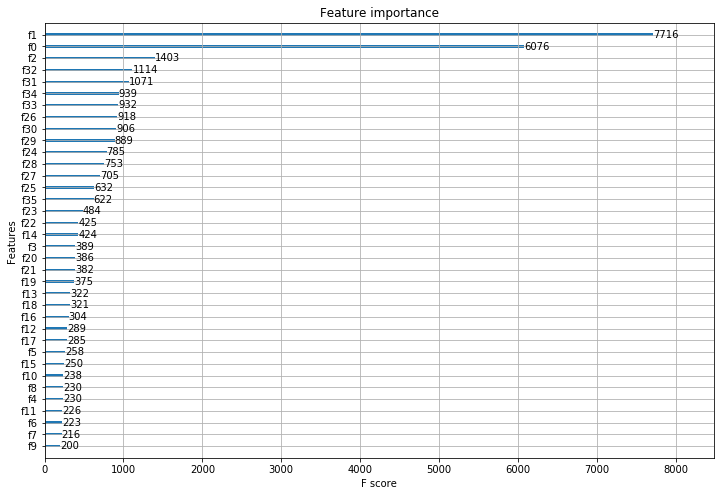

In [15]:
ax = xgb.plot_importance(xgb_train)
fig = ax.figure
fig.set_size_inches(12, 8)

#ax1 = xgb.plot_importance(xgb_train1)
#fig1 = ax1.figure
#fig1.set_size_inches(12, 8)
plt.show()

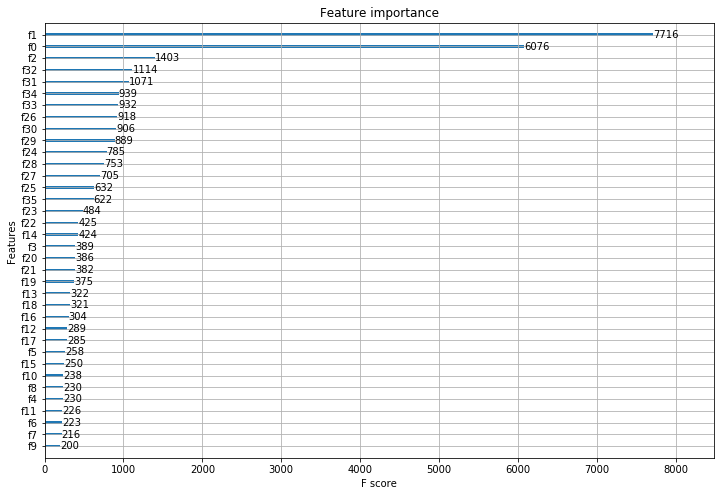

In [16]:
ax = xgb.plot_importance(xgb_train)
fig = ax.figure
fig.set_size_inches(12, 8)
plt.show()

sales_data: 
   date_block_num  shop_id  item_id  item_price  item_cnt_day Day Month  Year
0               0       59    22154       999.0           1.0  02    01  2013
1               0       25     2552       899.0           1.0  03    01  2013
2               0       25     2552       899.0          -1.0  05    01  2013
   shop_id  item_id  count
0        0       30      9
1        0       31      7
2        0       32     11
   date_block_num  item_cnt_day
0               0      131479.0
1               1      128090.0
2               2      147142.0
SALES_FIL2 shape: 
FILTERED: 
   shop_id  item_id
0        2      428
1        3      579
792
34
SHAPE OF "shop_item_uni"  42
34
Length of test shops is  42
Max shop is given by:  59
42
Shop Cnt Month shape is given by:  (34,)
PRINT0 34 45
34 42
THIS  [2385, 1535, 728, 544, 1062, 1865, 1271, 986, 631, 457, 755, 1047, 1230, 1667, 1430, 1528, 991, 845, 1168, 1036, 3137, 1294, 2138, 2649, 1395, 1675, 3386, 843, 1202, 1436, 915, 1036, 1851

[3 rows x 70 columns]
MUTUALLY EXCLUSIVE SETS:  (198954, 37) (15246, 4)
NEW Test_EXCLUSIVE SHAPE:  (15246, 4)
comm_items:  4737
exc_items 363
test_items 5100
 
final_comm_items SHAPE is given by:  (134200, 37)
   shop_id  item_id  cats    0     1    2    3    4    5    6 ...    24   25  \
0        0       30     7  0.0  31.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
1        1       30     7  0.0  10.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0   
2        2       30     7  0.0   0.0  1.0  0.0  0.0  1.0  0.0 ...   0.0  0.0   

    26   27   28   29   30   31   32   33  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 37 columns]
   shop_id  item_id  cats       0_x       1_x       2_x       3_x       4_x  \
0        5     5037     5  0.177542  0.177542  0.177542  0.177542  0.177542   
1        5     5233     5  0.177542  0.177542  0.177542  0.177542  0.177542   
2        5     5232     5  0.1775

C:\Users\Angadvir\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


(623078, 105)
sales_p.shape =  (424124, 37)
(42,) (5100,) 214200
test_merge:              ID  shop_id  item_id  cats
214195  214195       45    18454     8
214196  214196       45    16188     6
214197  214197       45    15757     8
214198  214198       45    19648     7
214199  214199       45      969     7
[30, 31, 32, 33, 38] [2, 3, 4, 5, 6]


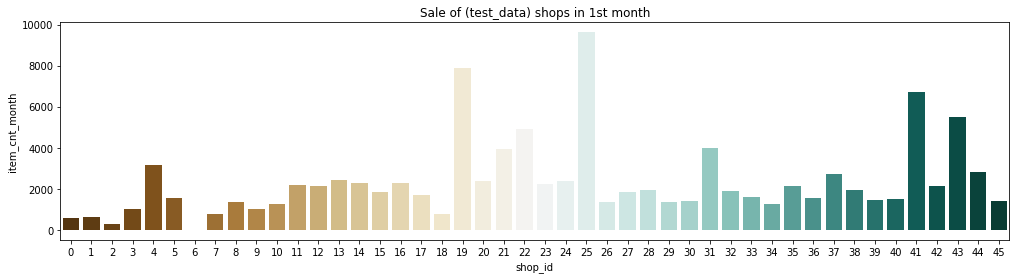

In [14]:
print('sales_data: ')
print(sales_data.head(3))

sales_data_uni = sales_data.groupby(['shop_id','item_id']).size().reset_index().rename(columns={0:'count'})
#print(sales_data_uni.head(3), sales_data_uni.shape) 

sales_month_cnt = sales_data.groupby(['date_block_num']).agg({'item_cnt_day': sum}).reset_index()

print(sales_data_uni[:3])
print(sales_month_cnt[:3])

Mo =[]
for i in range(34):
    Mo.append(i)
Z = sales_month_cnt

sales_fil1 = [0 for y in range(34)]
sales_fil2 = [0 for i in range(34)]

sales_fil = sales_data.groupby(['date_block_num','shop_id']).agg({'item_cnt_day':sum}) 
sales_fil = sales_fil.reset_index(level=['date_block_num', 'shop_id'])

for month in sales_fil['date_block_num']:  
    sales_fil1[month] = sales_fil.loc[sales_fil.date_block_num == month, 'item_cnt_day'].values
    sales_fil2[month] = sales_data.loc[sales_data.date_block_num == month]
d = -1

print('SALES_FIL2 shape: ')#, sales_fil2.shape)
#print(sales_fil2[:1])

#Find number of items sold by each shop in the 34th month:
sales_fil3 = sales_fil2[33].groupby('shop_id').agg({'item_id':'nunique'})
print('FILTERED: ')
#print(sales_fil3)

#Find number of items sold by each shop in all of the months [Method -2]:
sales_fil4 = [0 for i in range(34)]
for i in range(34):
   sales_fil4[i] = sales_fil2[i].groupby('shop_id').agg({'item_id':'nunique'})
   sales_fil4[i] = pd.DataFrame(sales_fil4[i], columns=['item_id']) 
   sales_fil4[i] = sales_fil4[i].reset_index()
   sales_fil4[i] = sales_fil4[i].rename(columns={sales_fil4[i].columns[0]:'shop_id', sales_fil4[i].columns[1]:'item_id'})

#THE ABOVE EQUATIONS COUNT THE NUMBER OF UNIQUE ITEMS SOLD IN EACH MONTH, BY EACH OF THE SHOPS:
#EX. sales_fil4[1] is the number of unique items sold by EACH of the shops in THAT MONTH [2nd month]:

#print(sales_fil4[5])
print(sales_fil4[2].head(2))
print(sales_fil4[5].item_id[2])
print(len(sales_fil4))
#SPLIT 'SALES_FIL4' INTO 34 DIFF DATAFRAMES:

#Storing the no. of unique items sold by each of the shops in all 34 months:
shop_item_uni = []#[0 for i in range(34)] 
for j in range(len(test_shops)):
    shop_item_uni.append([])
    for i in range(34):
        shop_item_uni[j].append(sales_fil4[i].item_id[j])

print('SHAPE OF "shop_item_uni" ', len(shop_item_uni))

print(len(shop_item_uni[1]))

#Plot the number of items sold by each: 
App = []
for n in (sales_fil1[3][:]):
     App.append(n)
        
#Computing number of shops in test set:
num_shops = test.groupby('shop_id')['shop_id'].nunique()
num_items = test.groupby('item_id')['item_id'].nunique()

#print(num_shops[:4])
test_shops = num_shops.index.values.tolist()
test_items = num_items.index.values.tolist()
print('Length of test shops is ', len(test_shops))
num_shops_train = sales_fil.groupby('date_block_num')['shop_id'].nunique()

item_cnt_month1 = [0 for i in range(34)] 

sales_fil = sales_fil.sort_values(by=['date_block_num'])

#Store the items sold by each of the shops in the test set: 
for month in sales_fil['date_block_num']:
    item_cnt_month1[month] = sales_fil.loc[sales_fil.date_block_num == month]    
    
print('Max shop is given by: ', max(test_shops))           
shop_cnt_month = [0 for p in range(len(test_shops))]   
shop_info = [0 for l in range(len(test_shops))]
k=-1
shop_t = []

#Store the items sold by each of the shops (in the test set) throughout the training section: 
for shop in test_shops:
    shop_t.append(shop)
    k = k+1
    shop_cnt_month[k] = sales_fil.loc[sales_fil.shop_id == shop, 'item_cnt_day'].values
    shop_cnt_month[k] = np.asarray(shop_cnt_month[k])
    shop_info[k] = pd.DataFrame(shop_cnt_month[k])
    shop_info[k] = shop_info[k].rename(columns = {0:'item_cnt_day'}) 

#Store the items sold by each of the shops (in the test set) throughout the training section: 
shop_month_agg = [0 for i in range(34)]
m = -1
    
#Testing dataframe construction:
print(len(shop_info))

Mo = []
for i in range(34):
    Mo.append(i)
    
#Printing out all the items sold by each shop over the (training set) time horizon:
'''
for k in range(10): 
   j = len(shop_cnt_month[k]) 
   #Convert to a DataFrame:
   #shop_info[k]= pd.DataFrame() 
   plt.figure(figsize=(12,3))
   plt.plot(Mo[:j], shop_cnt_month[k])
   plt.title('Monthly sales for shop_id: %d' %(k+1)) 
   plt.xticks(np.arange(min(Mo[:j]), max(Mo[:j])+1, 1.0)) 
plt.show()
'''

print('Shop Cnt Month shape is given by: ', shop_cnt_month[0].shape)
#Compute the moving average for each of the shops in the test set, over the given time horizon (34 months): 
shop_ewma = [0 for i in range(len(test_shops))]
date_block_num = [0 for i in range(len(test_shops))]
#Computing the exponential moving average for each of the shops (for all the items sold) , in the given time-frame (34 months):
for i in range(len(test_shops)):
   shop_ewma[i] = shop_info[i].ewm(com=0.5).mean()
   date_block_num[i] = list(shop_ewma[i].index.values)
    
#Test and plot it:
#print(shop_ewma[2])

'''
j = len(shop_cnt_month[2]) 
plt.figure(figsize=(12,3))
plt.plot(Mo[:j], shop_ewma[2])
plt.title('Exponential-Weighted MA for shop, %d' %2) 
plt.xticks(np.arange(min(Mo[:j]), max(Mo[:j])+1, 1.0)) 
plt.show()
'''
g = -1 

Arr = [0 for i in range(len(test_shops))]
Arr1 = []
t=-1
r=-1

for j in range(34):
  r=r+1
  Arr1.append([])
  for shop in range(len(test_shops)):
     t=t+1
     Arr1[j].append(sales_fil4[j].item_id[shop])  

Arr2 = []
print('PRINT0', len(sales_fil4), len(sales_fil4[0]))
for i in range(len(test_shops)):
    Arr2.append([])
    for j in range(34):
        Arr2[i].append(sales_fil4[j].item_id[i])
        
print(len(Arr1), len(Arr1[0]))
print('THIS ', Arr1[0])
print('Length for Arr2 is: ', len(Arr2), len(Arr2[0]))

aver = [0 for i in range(len(test_shops))]
aver1 = [0 for i in range(len(test_shops))]
#aver = [x/y for x, y in zip(shop_ewma, sales_fil3)]   
for j in range(len(test_shops)):
    aver[j] = shop_ewma[j][-1:]/Arr[j]
    aver1[j] = shop_ewma[j][-1:]/(30*Arr[j])
    
aver2 = [] #0 for i in range(len(test_shops))]
#shop_ewma = np.asarray(shop_ewma)

print('PRINT', Arr1[0][0], len(Arr1), len(Arr1[0]))
print('PRINT1', len(shop_ewma), len(shop_ewma[0]))

for k in range(len(shop_ewma)):
    aver2.append([])
    for i in range(len(shop_ewma[k])):
        aver2[k].append(shop_ewma[k].item_cnt_day[i]/(30*Arr2[k][i]))#shop_ewma[k].item_cnt_day[i]/Arr1[k][i])

print(len(aver2))
print('shop_ewma',shop_ewma[0])
print('Arr2', Arr2[0])

#sales_pivot = sales_data.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day', aggfunc='sum').fillna(0.0)

#Shape of 'aver2' is given by: 42 [34]. 
shop_aver = [0 for i in range(42)]

for j in range(42):
    shop_aver[j] = pd.DataFrame(aver2[j])
    shop_aver[j] = shop_aver[j].rename(columns = {0:'item_cnt_day'})
    shop_aver[j]['shop_id'] = test_shops[j] 
    shop_aver[j]['date_block_num'] = date_block_num[j]

data_fr1 = shop_aver[0]
for k in range((len(test_shops)-1)):
    data_fr1 = pd.concat([data_fr1, shop_aver[k+1]], ignore_index=True)

print(data_fr1.tail(10))
print(data_fr1.shape)

data_fr2 = data_fr1.pivot_table(index = ['shop_id'], columns = 'date_block_num', values = 'item_cnt_day')
data_fr2 = data_fr2.reset_index()

#Performing Fill_na:
mean_all = data_fr2.mean()
data_fr2 = data_fr2.fillna(mean_all.mean())
print('DATA_FR2.HEAD(): ')
print(data_fr2.tail(10))
print(data_fr2.shape)

print(test_merge.head(5)) 

test_items_on = test_set_only.groupby('item_id').agg({'item_id':'nunique'})
test_items_only1 = test_items_on.index.values.tolist()

#Replicate the 'items_cnt_day' for items repeated in both test and train sets:

#final_comm_items = pd.merge(test_exc, sales_p, how='inner', on=['item_id'])
final_comm_items = sales_p.loc[(sales_p['item_id'].isin(test_items))]

#Store items from 'final_comm_items':
comm_items_only = final_comm_items.groupby('item_id')['item_id'].nunique()
comm_items = comm_items_only.index.values.tolist()
final_exc_items = test_merged.loc[~(test_merged['item_id'].isin(comm_items))]
#Common items: [1,2,34,45,90,....,100] from a list of continuous numbers [1-100]:
#Uncommon items are: [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,..,88,89,91,94,96,98,99]

final_exc = final_exc_items.groupby('item_id')['item_id'].nunique()
exc_items = final_exc.index.values.tolist()
print('final_exc_items DATAFRAME SHAPE IS GIVEN BY: ', final_exc_items.shape)
print('Number of Test Exclusive Items Are: ', len(exc_items))

test_merge1 = [] 
#Change 'test_merge' to 'T_7':
test_n_merge = test_merge.loc[test_merge['item_id'].isin(comm_items)]
test_exc = test_merge.loc[~(test_merge['item_id'].isin(comm_items))]
test_exc1 = test_data.loc[~(test_data['item_id'].isin(comm_items))]
print('test_exc1.SHAPE: ', test_exc1.shape)

#Merge 'final_comm_items' with 'test_n_merge' dataset, to get 198,954 rows:
print('test_n_merge SHAPE: ', test_n_merge.shape)
print('final_comm_items: ', final_comm_items.shape)

#all_comm_items = pd.merge(final_comm_items, test_n_merge, how=['inner'], on=['item_id'])
all_comm_items = pd.concat([final_comm_items, test_n_merge], ignore_index=True, axis=1)
#all_comm_items_1 = pd.merge(final_comm_items, test_n_merge, how=['inner'], on = ['item_id'])

print('ALL_COMM_ITEMS: ',all_comm_items.shape)
print(all_comm_items.head(10))

#print('ALL_COMM_ITEMS_1: ', all_comm_items_1.shape)
#print(all_comm_item_1.head(4))

nu_nan = all_comm_items.iloc[:,37-41].isnull().sum()
#Drop last 4 columns:
all_comm_items1 = all_comm_items.drop(all_comm_items.columns[37:41], axis=1)

#df.drop(df.columns[22:56], axis=1, inplace=True)
print('After dropping: ')
all_comm_items1 = all_comm_items1.rename(columns={all_comm_items1.columns[0]: "shop_id",all_comm_items1.columns[1]: "item_id",all_comm_items1.columns[2]: "cat"})
#all_comm_items1 = all_comm_items1.rename(columns={all_comm_items1.columns[3::]: "shop_id")

for i in range(3,37):
    all_comm_items1 = all_comm_items1.rename(columns={all_comm_items1.columns[i]:i-3 })
    
print(all_comm_items1.tail(3))

#print('Number of NaNs: ',nu_nan.shape) 

print('MUTUALLY EXCLUSIVE SETS: ', test_n_merge.shape, test_exc.shape)
test_exclus = test_merge.loc[(test_merge['item_id'].isin(exc_items))]
print('NEW Test_EXCLUSIVE SHAPE: ', test_exclus.shape)

final_merge_t = pd.merge(test_n_merge, data_fr2, how='inner', on=['shop_id'])
#final_merge_tt = pd.merge(test_n_merge, sales_p, how='inner', on=['shop_id'])
#JUST SELECT THE ROWS IN SALES_P WHICH MATCH THE ITEMS IN "T_7_items"
#print('final_merge_tt.shape is given BY: ', final_merge_tt.shape)

final_merge_t2 = pd.merge(test_exc, data_fr2, how='inner', on=['shop_id'])

#Compare ALL common items here:
print('comm_items: ', len(comm_items))
print('exc_items', len(exc_items))
print('test_items',len(test_items))
#print('exc_items: ', len(exc_items))
print(' ')

print('final_comm_items SHAPE is given by: ', final_comm_items.shape)
print(final_comm_items[:3])

#FILTER THIS SECTION OUT:
#############################
print(final_merge_t.head(5))
print('final_merge_t shape is given by: ', final_merge_t.shape)
print('final_merge_t head of 5: ', final_merge_t.head(5))

print('final_merge_t2 shape is given by: ', final_merge_t2.shape)
print('final_merge_t2 head of 5: ', final_merge_t2.head(5))
#############################

final_merge_t1 = final_merge_t.loc[(final_merge_t['item_id'].isin(test_items_only1))]
print('FINAL_MERGE_T1.SHAPE IS GIVEN BY:', final_merge_t1.shape)

print(final_merge_t.shape)
train_set_all1 = sales_p.append(final_merge_t) #+Test_Exclusive_items

print(train_set_all1.shape)
#Counting no. of nans in datasets:
count_nan = train_set_all1.isnull().sum()
count_nan1 = final_merge_t.isnull().sum()

#print(train_set_new.shape)
print('sales_p.shape = ',sales_p.shape)
#item sold/day in each of the 34 months by each of the 42 shops in the "Test_data": ')

#Make predictions on the test data set: 
for month in sales_fil['date_block_num']:
    item_cnt_month1[month] = item_cnt_month1[month].astype(int)
    item_cnt_month1[month] = pd.DataFrame(item_cnt_month1[month], columns =['date_block_num', 'shop_id', 'item_cnt_day'])
    
item_cnt_month = [0 for i in range(34)]
item_cnt_month2 = []

P = []
print(num_shops.shape, num_items.shape, num_shops.shape[0]*num_items.shape[0])

F = []        
for j in range(len(App)):
    F.append(j)

Ze = np.c_[F, App]
Ze = pd.DataFrame(Ze, columns=['shop_id', 'item_cnt_month'])
#print(Z[:3])
Ze.shop_id = Ze.shop_id.astype(int)

fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (17,4))
sns.barplot(data=Ze, x='shop_id', y='item_cnt_month', ax = ax, palette="BrBG")
plt.title('Sale of (test_data) shops in 1st month') 

test_items_on = test_set_only.groupby('item_id').agg({'item_id':'nunique'})
test_items_only1 = test_items_on.index.values.tolist()
#print(len(test_items_only1))
#print(test_items_only1[:4], test_items_only1[-4:])
print('test_merge: ', test_merge.tail(5))
print(test_items[:5], test_shops[:5])

In [17]:
#train_set_all1_f = train_set_all1[train_set_all1.33 > 100]
#final_merge_t_f = final_merge_t[train_set_all1.33 > 100]
#print(train_set_all1_f)
#print(final_merge_t_f)
print(mean_all.mean())
df_t = mean_all.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]]
print(df_t.mean())
#Filtering the dataset:
train_set_all1 = train_set_all1.fillna(mean_all.mean())
final_merge_t = final_merge_t.fillna(mean_all.mean())
train_set_all1 = train_set_all1.replace([np.inf, -np.inf], mean_all.mean())

1.1517653242432673
1.182728228010546


In [18]:
#Training an XGBoost model on test_items and test_shops only: 
param = {'max_depth': 22,
         'eta': 0.30,
         'min_child_weight': 0.55,
         'booster': 'gbtree',
         'nthread': 4, 
         'eval_metric': 'rmse', 
         'gamma': 0.80,
         'seed': 342, #342,
         'silent': 1,
         'num_round': 2000
         }

#Training XGBoost on ENTIRE train data and testing on test_items and test_shops only:
xgb_data = []
xgb_train = []
xgb_data = xgb.DMatrix(train_set_all1.iloc[:,(train_set_all1.columns!=33)].values, label=train_set_all1.iloc[:,(train_set_all1.columns==33)].values)
xgb_train = xgb.train(param, xgb_data)
xgb_pred = xgb_train.predict(xgb.DMatrix(final_merge_t.iloc[:,(final_merge_t.columns!=33)].values))
accur = np.sqrt(mean_squared_error(final_merge_t.iloc[:,(final_merge_t.columns==33)].values, xgb_pred))
print(accur)

'''
#Training a RandomForestRegressor on ENTIRE train data and testing on ENTIRE train set: 
RF_mod = RandomForestRegressor(n_estimators=80, max_depth=15, random_state=3, verbose=1)
RF_train = RF_mod.fit(train_set_all1.iloc[:,(train_set_all1.columns!=33)].values, np.ravel(train_set_all1.iloc[:,(train_set_all1.columns==33)].values))
RF_pred = RF_train.predict(train_set_all1.iloc[:,(train_set_all1.columns!=33)].values)
print(np.sqrt(mean_squared_error(train_set_all1.iloc[:,(train_set_all1.columns==33)].values, RF_pred)))

#Training RandomForestRegressor on ENTIRE train data and testing on test_items and test_shops only:
RF_mod1 = RandomForestRegressor(n_estimators=80, max_depth=24, random_state=3, verbose=1)
RF_train1 = RF_mod1.fit(train_set_all1.iloc[:,(train_set_all1.columns!=33)].values, np.ravel(train_set_all1.iloc[:,(train_set_all1.columns==33)].values))
RF_pred1 = RF_train1.predict(final_merge_t.iloc[:,(final_merge_t.columns!=33)].values)
print(np.sqrt(mean_squared_error(final_merge_t.iloc[:,(final_merge_t.columns==33)].values, RF_pred1)))
'''

#Implementing LightGBM:
GBM_3 = []
GBM_3 = GradientBoostingRegressor(n_estimators = 70, learning_rate = 0.1, max_depth=5, 
                                  random_state =2 ,loss ='ls', verbose=1).fit(train_set_all1.iloc[:,(train_set_all1.columns!=33)].values, train_set_all1.iloc[:,(train_set_all1.columns==33)].values)
GBM_3_pred = GBM_3.predict(final_merge_t.iloc[:,(final_merge_t.columns!=33)].values) 
accur1 = np.sqrt(mean_squared_error(final_merge_t.iloc[:,(final_merge_t.columns==33)].values, GBM_3_pred))
print(accur1)

param1 = {'max_depth': 22,
         'eta': 0.30,
         'min_child_weight': 0.55,
         'booster': 'gbtree',
         'nthread': 4, 
         'eval_metric': 'rmse', 
         'gamma': 0.80,
         'seed': 2, #342,
         'silent': 1,
         'num_round': 1000
         }
conc = np.c_[xgb_pred, GBM_3_pred]

#Implementing Stacking on the previous 2 base-learners (using an XGBoost model):
xgb_data_2 = xgb.DMatrix(conc, label=final_merge_t.iloc[:,(final_merge_t.columns==33)].values)
xgb_train_2 = xgb.train(param1, xgb_data_2)
xgb_pred_2 = xgb_train_2.predict(xgb.DMatrix(conc))
accur_2 = np.sqrt(mean_squared_error(final_merge_t.iloc[:,(final_merge_t.columns==33)].values, xgb_pred_2))
print(accur_2)

#Base Learner_1:
A = []
for i in range(len(xgb_pred)):
    A.append(i)
xgb_pred1 = np.c_[A, xgb_pred]    
np.savetxt("Coursera_Comp_XGBMmodel_short.csv", xgb_pred1, delimiter=" ")

#Base Learner_2:
B = []
for i in range(len(GBM_3_pred)):
    B.append(i)
lgb_pred1= np.c_[B, GBM_3_pred] 
np.savetxt("Coursera_Comp_LightGBMmodel_short.csv", lgb_pred1, delimiter=" ")

#Stacked Predictions:
stack_pred = np.c_[B, xgb_pred_2]
np.savetxt("Coursera_Comp_STACKED_short.csv", stack_pred, delimiter=" ")

df_out1 = pd.DataFrame(xgb_pred1, columns=['ID','item_cnt_month'])
df_out2 = pd.DataFrame(lgb_pred1, columns=['ID', 'item_cnt_month'])
df_stack = pd.DataFrame(stack_pred, columns=['ID', 'item_cnt_month'])

print(df_out1.head(15))
#print(df_out1.shape)
print(df_out2.head(15))
#print(df_out2.shape)
print(df_stack.head(15))

#Future Improvements: 
#Implement Stacking on the TEST train set data, where the meta_features (base_learner predictions) are tested on the TEST set only.
#Explore various averaging techniques (EWMA, MA, Average). 
#Include row mean, instead of overall_mean
#Try some other model, instead of XGBoost.
#Try to train only on the test set shops and items and predict that model on the final test set.
#REPLACE THE ITEMS WHCIH ARE BOTH IN THE TRAIN AND TEST SET WITH ACTUAL (REALIZED) VALUES FOR ITEM_CNT_DAY.

0.4809094919967155


C:\Users\Angadvir\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           8.8964            3.01m
         2           7.3996            2.79m
         3           6.1858            2.60m
         4           5.1999            2.40m
         5           4.3980            2.32m
         6           3.7461            2.32m
         7           3.2181            2.24m
         8           2.7899            2.16m
         9           2.4409            2.11m
        10           2.1571            2.08m
        20           1.0660            1.87m
        30           0.9105            1.55m
        40           0.8639            1.19m
        50           0.8437           48.85s
        60           0.8249           25.72s
        70           0.8092            0.00s
0.33657305458280334
0.015508484962107324
      ID  item_cnt_month
0    0.0        0.042628
1    1.0        0.042628
2    2.0        0.042628
3    3.0        0.042628
4    4.0        0.042628
5    5.0        0.042628
6    6.0        0.

In [85]:
#Counting number of unique shop_id's in sales_data:
sales_data_shop_uni = sales_data.groupby(['shop_id']).size().reset_index().rename(columns={0:'count'})

sales_data_shop_uniq = sales_data.groupby('shop_id')['shop_id'].nunique()

sales_data_item_uniq = sales_data.groupby('item_id')['item_id'].nunique()
print(sales_data_shop_uniq[-3:])

print(sales_data_item_uniq.shape)
print(sales_data_shop_uniq.shape[0]*sales_data_item_uniq.shape[0]) 
#Filter all shops, which are present in the test set:
test_shops = num_shops.index.values.tolist()
test_items = num_items.index.values.tolist()

train_filter = [0 for i in range(len(test_shops))]

print(len(test_shops))
k=-1 
for shops in test_shops: 
    k=k+1
    train_filter[k] = sales_data.loc[sales_data.shop_id == shops]
    train_filter[k] = pd.DataFrame(train_filter[k], columns = ['date_block_num','shop_id','item_id','item_price','item_cnt_day','Day','Month','Year'])

#Concatinating all the pandas dataframes: 
dfr1 = train_filter[0]
for k in range((len(test_shops)-1)):
    dfr1 = pd.concat([dfr1, train_filter[k+1]], ignore_index=True)
    
print(train_filter[0].shape)
print(dfr1.shape)

#Select only items, which are present in the test set: 
train_filter1 = [0 for i in range(len(test_items))]

dfr2 = dfr1.loc[dfr1.item_id.isin(test_items)]   

print(dfr2.shape)  

#Storing a filtered training set:
train_filtered = dfr2.copy()

test_filtered = train_filtered.loc[train_filtered.date_block_num == 33]
print(test_filtered.shape)

#Obtain target variables for the test_set: 
test_filter = sales_data.loc[sales_data.date_block_num == 33]
#print(test_filter.shape)

#test_filter_shops_nu = test_filter.groupby('shop_id')['item_id'].nunique
test_filter_shops_nu = test_filter.groupby('shop_id').agg({'shop_id': 'nunique'})

#test_filter_items_nu = test_filter.groupby('shop_id')['item_id'].nunique
test_filter_items_nu = test_filter.groupby('item_id').agg({'item_id': 'nunique'})
#print(test_filter.head(3), min(test_filter.shop_id),max(test_filter.shop_id), min(test_filter.item_id), max(test_filter.item_id))
test_filter1 = test_filter.loc[test_filter.shop_id.isin(test_shops)]

test_filter2 = test_filter1.loc[test_filter1.item_id.isin(test_items)] 

shop_id
57    1
58    1
59    1
Name: shop_id, dtype: int64
(21807,)
1308420
42
(25991, 8)
(2413246, 8)
(1224439, 8)
(49532, 8)
